# Mapping human Paed thymus Visium sections with selection of cell proportions and genes


## Loading packages <a class="anchor" id="Loading_packages"></a>

In [2]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

Global seed set to 0
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100
from datetime import date
today = str(date.today())
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'pdf')

sc.settings.verbosity = 1
sc.logging.print_version_and_date()
%load_ext autoreload
%autoreload 2

Running Scanpy 1.9.1, on 2023-09-20 09:22.


In [4]:
import os
os.getcwd()

'/nfs/team205/ny1/ThymusSpatialAtlas/Figure2'

First, let's define where we save the results of our analysis:

In [5]:
results_folder = ''
# os.mkdir(results_folder)
# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [5]:
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'pdf')

## Loading scRNA-seq reference data <a class="anchor" id="Loading_Visium"></a>

In [6]:
adata_ref_all = sc.read("")
#adata_ref_all.X = adata_ref_all.layers['counts']
#del adata_ref_all.layers['counts']

In [7]:
adata_ref = adata_ref_all[adata_ref_all.obs['age_group'] != 'fetal', :].copy()

In [8]:
adata_ref.shape

(343855, 36751)

In [9]:
adata_ref.obs['study'].value_counts()

SpatialAtlas-Taghon       159480
Park2020                  104137
SpatialAtlas-Teichmann     68351
Bautista2021                7633
Campinoti2020               4254
Name: study, dtype: int64

In [10]:
adata_ref.obs['cell_type_level_4'].value_counts().loc[adata_ref.obs['cell_type_level_4'].value_counts()<40]

PeriloFb-Prolif     38
InterloFb-COL9A3    38
Macrophage-LYVE1    22
Promonocyte         18
EC-Cap-Prolif       17
Mast                17
pDC-Prolif          13
pro_B               13
ProlifPericyte      12
GMP                 11
fetFB-NKX2-5        10
Monocyte_CCR2        9
RBC                  7
T_cycling            6
fetFB-CCL21          6
nmSchwann            4
fetFB-RSPO2          4
late_pro_B           4
large_pre_B          1
Mesothelium          1
T_NK_dev             1
Name: cell_type_level_4, dtype: int64

In [11]:
prolif_cells = ['DC1-Prolif', 'DC2-Prolif', 'pDC-Prolif', 'PeriloFb-Prolif', 'ProlifPericyte','mcTEC-Prolif',
               'B-Prolif']
fet_specific = ['pro_B', 'late_pro_B', 'large_pre_B', 'small_pre_B', 'CMP', 'GMP', 'InterloFb-COL9A3',
                'fetFB-NKX2-5', 'fetFB-CCL21','fetFB-RSPO2', 'Mesothelium', 'mcTEC-Prolif',
               'T_NK_fetal', ]
unclear = ['T_DP(Q)-HSPH1','T_SP8or4','T_SP-HSP','T_DN(Q)-stress_1','T_DN(Q)-stress_2','T_DN(Q)-intermediate','T_Treg-intermediate','T_innate_type_3']
to_remove = set(adata_ref.obs['cell_type_level_4'].value_counts().loc[adata_ref.obs['cell_type_level_4'].
                                                                      value_counts()<=40].index.tolist()+
            prolif_cells + fet_specific + unclear)

### Plot removed cells and their numbers

In [12]:
adata_ref.obs.loc[adata_ref.obs['cell_type_level_4'].isin(to_remove), 'cell_type_level_4'].value_counts()[adata_ref.obs.loc[adata_ref.obs['cell_type_level_4'].isin(to_remove), 'cell_type_level_4'].value_counts()!=0]

T_DP(Q)-HSPH1           4560
T_DN(Q)-stress_1        2899
T_DN(Q)-intermediate    1910
T_SP8or4                1677
T_SP-HSP                1349
T_innate_type_3          512
T_DN(Q)-stress_2         450
T_NK_fetal               315
DC1-Prolif               139
T_Treg-intermediate      110
mcTEC-Prolif              84
small_pre_B               78
B-Prolif                  75
DC2-Prolif                54
CMP                       44
EC-Ven-ELN                40
InterloFb-COL9A3          38
PeriloFb-Prolif           38
Macrophage-LYVE1          22
Promonocyte               18
Mast                      17
EC-Cap-Prolif             17
pro_B                     13
pDC-Prolif                13
ProlifPericyte            12
GMP                       11
fetFB-NKX2-5              10
Monocyte_CCR2              9
RBC                        7
T_cycling                  6
fetFB-CCL21                6
late_pro_B                 4
fetFB-RSPO2                4
nmSchwann                  4
Mesothelium   

In [13]:
adata_ref.obs['rm_paed_Vismap'] = adata_ref.obs['cell_type_level_4'].isin(to_remove)
adata_ref.obs['rm_paed_Vismap']  = adata_ref.obs['rm_paed_Vismap'].astype(str)

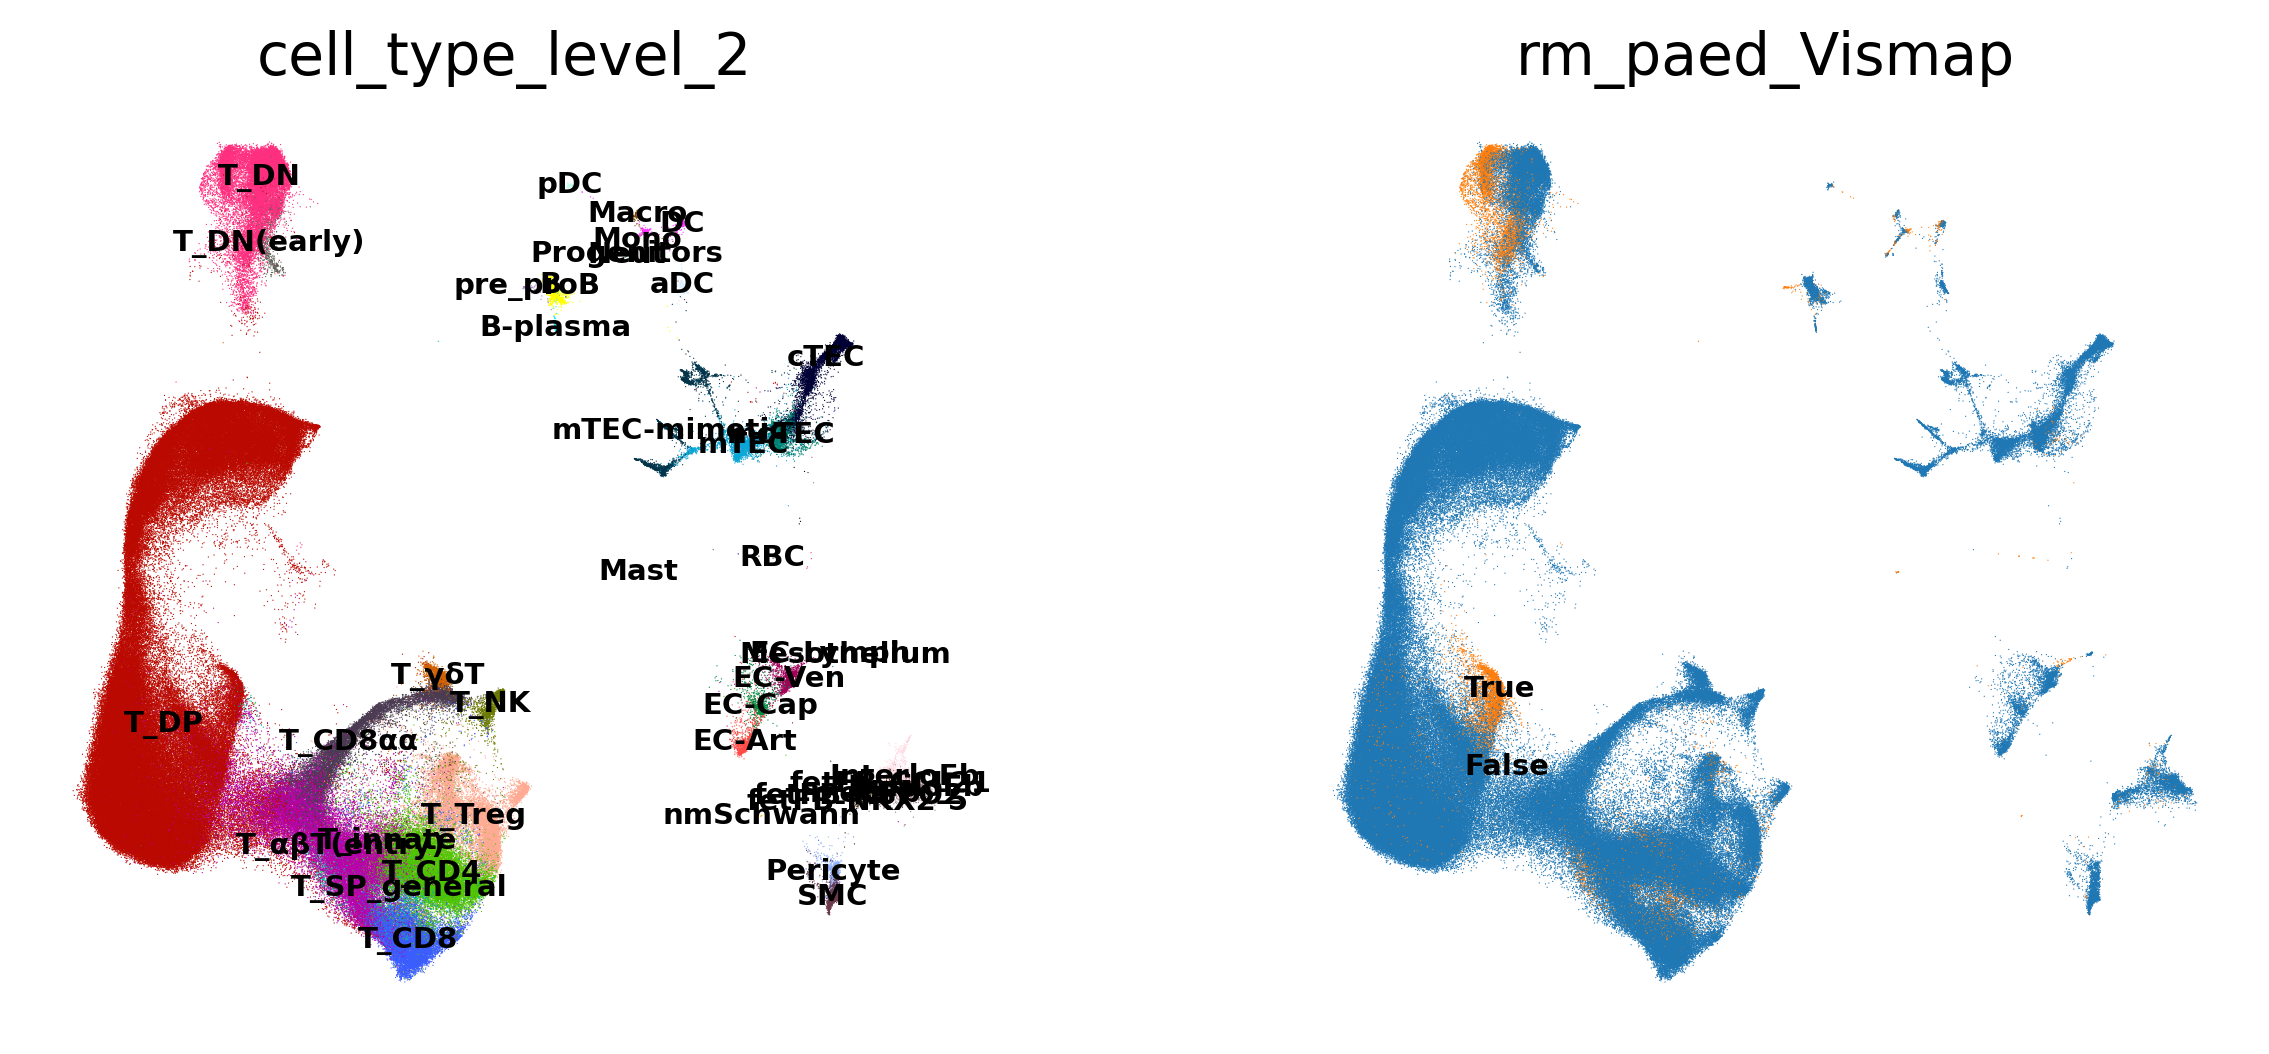

In [14]:
sc.pl.umap(adata_ref, color = ['cell_type_level_2', 'rm_paed_Vismap'], legend_loc = "on data", 
          legend_fontsize = 7, frameon = False)

In [15]:
# remove cells for paed that are fetal specific, proliferating, too low in abundance or of unclear importance
adata_ref = adata_ref[~adata_ref.obs['cell_type_level_4'].isin(to_remove),:].copy()
# adata_ref.obs['cell_type_level_4'].value_counts()

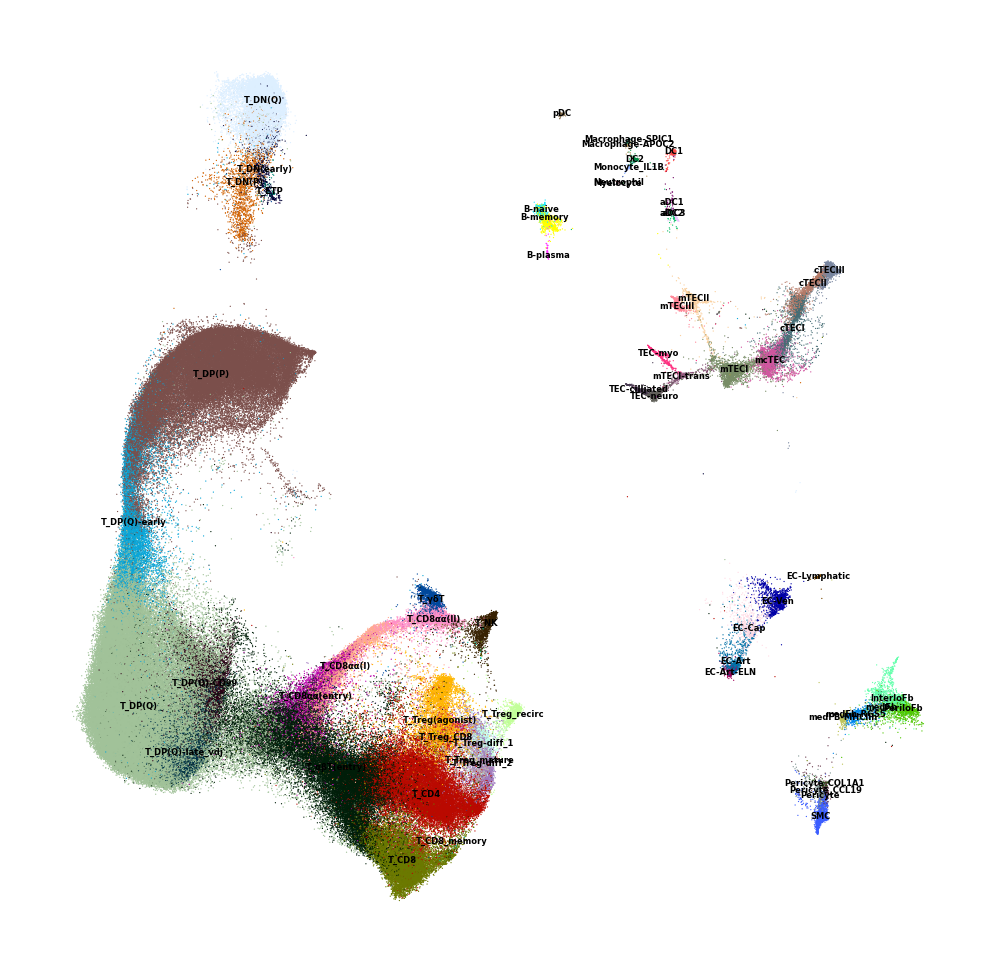

In [16]:
sc.pl.umap(adata_ref, color = ['cell_type_level_4'], legend_loc = "on data", 
          legend_fontsize = 2, frameon = False, title = "")

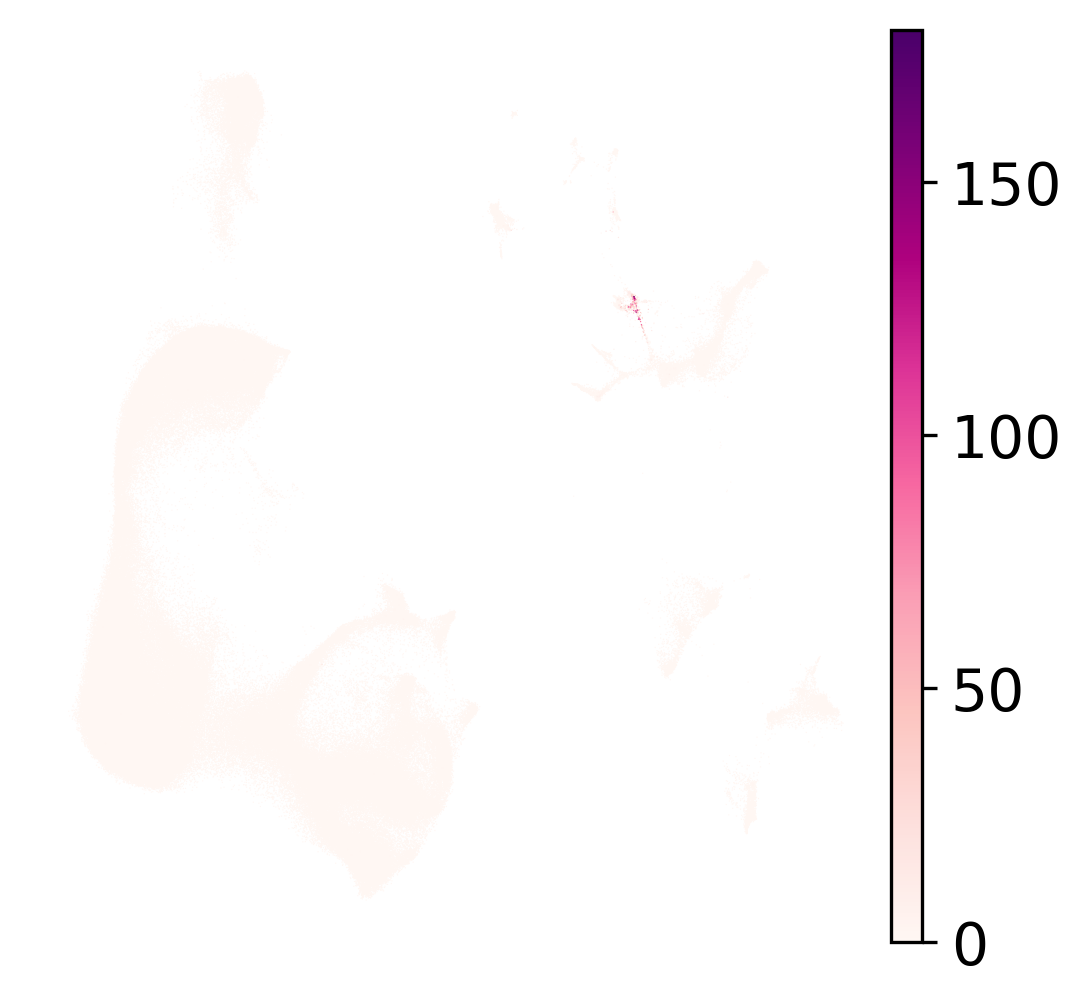

In [17]:
# check counts data 
sc.pl.umap(adata_ref, color = ['AIRE'], legend_loc = "on data", 
          legend_fontsize = 2, frameon = False, title = "")

In [18]:
# downsample source both by max count and cell type
target_cells = 10000 # top proportion
target_cells_subclass = 1000 # top proportion of selected cells
cluster_key = 'cell_type_level_4'
adatas = [adata_ref[adata_ref.obs[cluster_key].isin([clust])] for clust in list(adata_ref.obs[cluster_key].cat.categories)]

for dat in adatas:
    if dat.n_obs > target_cells_subclass:
        if np.unique(dat.obs['cell_type_level_4'].isin(['nan']))[0]:
            sc.pp.subsample(dat, n_obs=target_cells_subclass)
            print("here")
        else:
            if dat.n_obs > target_cells:
                sc.pp.subsample(dat, n_obs=target_cells)

adata_ref = adatas[0].concatenate(*adatas[1:])
adata_ref.obs['cell_type_level_4'].value_counts()

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


T_DN(Q)             10000
T_αβT(entry)        10000
T_DP(P)             10000
T_DP(Q)             10000
T_CD4               10000
T_CD8               10000
T_DP(Q)-early        9214
T_Treg(agonist)      5452
T_DP(Q)-CD99         5361
T_DP(Q)-late_vdj     4746
T_CD8αα(entry)       4644
T_CD8αα(I)           4352
T_CD8αα(II)          3856
T_Treg-diff_2        3300
mcTEC                3116
mTECI                2880
cTECIII              2153
T_NK                 2105
cTECI                1967
T_DN(P)              1698
T_γδT                1609
cTECII               1589
SMC                  1567
EC-Ven               1539
B-memory             1464
T_Treg-diff_1        1431
PeriloFb             1320
T_Treg_mature        1241
TEC-neuro            1235
InterloFb            1233
T_Treg_recirc        1200
B-naive              1126
EC-Cap                865
mTECII                789
mTECIII               742
EC-Art                720
T_Treg_CD8            663
T_DN(early)           653
medFb-RGS5  

## Highly variable gene selection

In [19]:
adata_ref.shape

(140714, 36751)

In [20]:
# remove vdj genes - code from kelvin 
import re
adata_ref.var['vdj'] = False
for i in adata_ref.var.index:
    if re.search('^TR[AB][VDJ]|^IG[HKL][VDJC]', i):
        adata_ref.var.at[i, 'vdj'] = True
adata_ref = adata_ref[:,~adata_ref.var['vdj']]
adata_ref


View of AnnData object with n_obs × n_vars = 140714 × 36155
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_cou

In [21]:
adata_ref = adata_ref[:,~adata_ref.var['cite']] # remove cite genes

In [22]:
# remove cell cycle genes and MT genes (optinal) 
cc_genes =  ['C1orf112', 'KDM1A', 'ARHGAP33', 'CDC27', 'AC004381.6', 'DBF4', 'PRSS21', 'E2F2', 'BAZ1B', 'NCAPD2', 'ANLN', 'BRCA1', 'UBR7', 'DDX11', 'TACC3', 'POLA2', 'DEPDC1', 'NCAPH2', 'HMGB3', 'CENPQ', 'DEPDC1B', 'SPDL1', 'TDP1', 'DSG2', 'NOP16', 'RFC2', 'RAD51', 'POLQ', 'THOC3', 'MRTO4', 'C4orf27', 'POLD1', 'TM7SF3', 'MCM10', 'MTHFD2', 'YBX1', 'ASPM', 'PRR11', 'NUCKS1', 'EXOC5', 'TCOF1', 'RAD18', 'TRIP13', 'DAZAP1', 'HLTF', 'PDCD2', 'SMC1A', 'HMMR', 'MCM2', 'NUP37', 'GTSE1', 'WDR62', 'MCM6', 'MLH1', 'UNG', 'SPAG5', 'UBE2T', 'EXOSC5', 'FAM76B', 'POLD3', 'KIF22', 'PUM3', 'RBL1', 'NDC80', 'HSPB11', 'OXCT1', 'SEH1L', 'ORC1', 'RAD54L', 'NOP14', 'GMCL1', 'AURKA', 'TPX2', 'BIRC5', 'KIF4A', 'FH', 'ORC6', 'G2E3', 'WDR76', 'PHGDH', 'CLSPN', 'NUP50', 'CDC45', 'CDC6', 'CBX5', 'MSH2', 'FKBP5', 'ACOT7', 'CDC7', 'RANBP1', 'CENPM', 'HMGXB4', 'MCM5', 'RANGAP1', 'POLE2', 'CDKN3', 'ERH', 'MTHFD1', 'VRK1', 'EMC9', 'GINS1', 'MYBL2', 'CDC25B', 'PLCB4', 'FAM83D', 'CEP76', 'RBBP8', 'POLA1', 'NUP93', 'CTCF', 'CCP110', 'CEP152', 'OIP5', 'MYEF2', 'MCM4', 'KCTD9', 'RNASEH2A', 'SGTA', 'ASF1B', 'LIG1', 'H2AFV', 'GARS', 'NUDT1', 'RPA3', 'EZH2', 'RHEB', 'SMC3', 'UBE2S', 'RAD51C', 'GALK1', 'C1QBP', 'BLMH', 'TMEM97', 'GAR1', 'NEIL3', 'WHSC1', 'NCAPG', 'CCDC34', 'CCDC86', 'MAGOHB', 'FOXM1', 'GPN3', 'RAD51AP1', 'RFC5', 'NUP107', 'TIMELESS', 'GAPDH', 'CDCA3', 'ENO2', 'FBXO5', 'MCM3', 'BAG2', 'GMNN', 'TTK', 'HMGCS1', 'BRD8', 'KIF20A', 'LMNB1', 'NUP155', 'H2AFY', 'SMC4', 'ECT2', 'CENPA', 'FHL2', 'MSH6', 'DHCR24', 'LRRC42', 'WDR77', 'SRM', 'MAD2L2', 'UCHL5', 'TTF2', 'SLC2A1', 'EBNA1BP2', 'CDC20', 'STMN1', 'NEK2', 'CENPF', 'KIF14', 'CASP8AP2', 'CTNNAL1', 'WDR34', 'PHF19', 'ACYP1', 'EPCAM', 'HELLS', 'CENPL', 'ACAT2', 'MASTL', 'EXOSC8', 'TMPO', 'NFYB', 'NCAPH', 'MND1', 'KIF18A', 'GPSM2', 'GTF3A', 'MRPS2', 'CCDC18', 'CISD1', 'ZWINT', 'CIT', 'DDX39A', 'CENPK', 'CDK2', 'TUBA1B', 'STIL', 'HJURP', 'EXOSC9', 'CKS2', 'ACSL3', 'CSE1L', 'HIST1H1D', 'HIST1H1A', 'DEK', 'GOT2', 'MGME1', 'MCM8', 'HNRNPR', 'BCL2L12', 'TRAP1', 'DLGAP5', 'YEATS4', 'PKMYT1', 'SRD5A3', 'PAICS', 'HAT1', 'KNSTRN', 'DUT', 'E2F8', 'FAM64A', 'MIS18BP1', 'SGOL1', 'RPS4Y1', 'LDLR', 'TOMM40', 'ATP8B3', 'LSM4', 'DNMT1', 'GINS2', 'TUBG1', 'PSMC3IP', 'THOC6', 'TOP2A', 'ENOSF1', 'RAN', 'RPA1', 'PCNA', 'NASP', 'RFC3', 'SLF1', 'LRRCC1', 'CCNB1', 'PSRC1', 'TMEM106C', 'LDHA', 'DDB2', 'CDCA8', 'TPGS2', 'SLC43A3', 'C9orf40', 'TROAP', 'ESPL1', 'NTPCR', 'CKAP2', 'BORA', 'NUDT15', 'BRIP1', 'ACTL6A', 'TXN', 'ODF2', 'SMC2', 'CDK5RAP2', 'ANP32B', 'DSCC1', 'ARHGEF39', 'PPIL1', 'TCF19', 'NRM', 'GGH', 'BUD13', 'CTDSPL2', 'NUSAP1', 'KIF23', 'CASC5', 'CENPO', 'KIF11', 'CEP55', 'KIF20B', 'DNA2', 'BARD1', 'MNS1', 'ZGRF1', 'CENPE', 'HADH', 'SLC39A8', 'NEDD1', 'BRCA2', 'DIAPH3', 'PIF1', 'FANCI', 'TICRR', 'SAMD1', 'SAE1', 'PLK4', 'ITGB3BP', 'KIF2C', 'UCK2', 'NUF2', 'ANP32E', 'DTL', 'ILF2', 'C1orf35', 'HNRNPLL', 'CHAC2', 'POLR2D', 'CDCA7', 'FANCD2', 'CCNA2', 'SKP2', 'PRIM2', 'MMS22L', 'PM20D2', 'MTFR2', 'CDCA5', 'NCAPG2', 'PRPS1', 'GINS4', 'HAUS6', 'CEP78', 'GTF3C5', 'MKI67', 'IMMP1L', 'SSRP1', 'INCENP', 'CCDC15', 'CHEK1', 'DSN1', 'HIRIP3', 'HMGA2', 'TEX30', 'NCAPD3', 'CENPU', 'CENPJ', 'SPC25', 'SUV39H2', 'CENPH', 'CARHSP1', 'CLGN', 'CCSAP', 'BUB3', 'SLFN13', 'SKA1', 'SLC16A1', 'TMEM237', 'ADK', 'FAM122B', 'AIFM1', 'ATAD2', 'SASS6', 'BUB1B', 'CCNB2', 'PSMG3', 'FAIM', 'CDC25C', 'MIS18A', 'ATP5G1', 'IGF2BP1', 'CHAF1B', 'NAE1', 'CCDC58', 'C21orf58', 'ZNF714', 'GPATCH4', 'YDJC', 'RACGAP1', 'SPC24', 'POLR3K', 'CCNF', 'ASRGL1', 'USP1', 'KIAA1524', 'SGOL2', 'TOPBP1', 'KIF15', 'WDR43', 'RFC4', 'RPL39L', 'RNF168', 'H2AFZ', 'CDC25A', 'POC1A', 'HMGB2', 'MAD2L1', 'PTTG1', 'RAD21', 'PSIP1', 'GKAP1', 'MELK', 'SLC7A3', 'SKA3', 'LRR1', 'HPRT1', 'E2F7', 'JAM3', 'BRD7', 'CENPN', 'LEO1', 'WEE1', 'MCM7', 'CENPV', 'SAAL1', 'FAM111A', 'KIAA0101', 'PLK1', 'XRCC6BP1', 'SNRPD1', 'RRM1', 'CDT1', 'CHAF1A', 'C19orf48', 'NUDT8', 'PRDX2', 'TK1', 'SAC3D1', 'PBK', 'HIST1H1E', 'DTYMK', 'RFWD3', 'FEN1', 'ING2', 'CDKN2AIP', 'SNRNP48', 'USP39', 'CKAP2L', 'BUB1', 'ELP5', 'CDK1', 'CDCA4', 'SHCBP1', 'PGAM1', 'ESCO2', 'RHNO1', 'CTPS1', 'RRM2', 'THOP1', 'C5orf34', 'POP7', 'ZNF738', 'CKS1B', 'GMPPB', 'CNP', 'CBX2', 'C16orf91', 'EXO1', 'ZWILCH', 'ANKRD36C', 'UBE2C', 'CKAP5', 'CCNE2', 'CCDC14', 'RMI2', 'TOMM5', 'RUVBL1', 'ATAD5', 'LMNB2', 'TYMS', 'PXMP2', 'SHMT1', 'POLE', 'PAWR', 'PIDD1', 'GSG2', 'GEN1', 'RMI1', 'AURKB', 'RCC1', 'PPA1', 'HIST3H2A', 'MRPS23', 'RTKN2', 'IDH2', 'KPNA2', 'CEP97', 'GLRX5', 'SKA2', 'CEP57L1', 'PSMG1', 'SFXN4', 'ALYREF', 'TRAIP', 'LIN9', 'KMT5A', 'PGP', 'CMSS1', 'HIST2H2AC', 'HIST1H1B', 'KNTC1', 'CDCA2', 'H1FX', 'SIVA1', 'PARPBP', 'KIF18B', 'ERCC6L', 'PTMA', 'HSPA14', 'FANCA', 'ARHGAP11B', 'TUBB4B', 'CENPP', 'H2AFX', 'FAM72B', 'FAM221A', 'FAM111B', 'HN1', 'HMGB1', 'TUBB', 'IARS', 'ERI2', 'HIST1H4C', 'BLM', 'PRIM1', 'HMGN5', 'SVIP', 'TFDP1', 'TXNRD1', 'WDHD1', 'EIF1AY', 'ARHGAP11A', 'HMGN2', 'DCAF12', 'PRC1', 'CCDC167', 'CENPW', 'GPANK1', 'MZT1', 'C4orf46', 'KLHL23', 'MXD3', 'DNAJC9', 'IFRD2', 'CKLF', 'FANCG', 'DHFR', 'DLEU2', 'AP000251.3', 'KIFC1', 'CRNDE', 'C8orf88', 'PRKDC', 'BOP1', 'RP11-196G18.23', 'CTC-260E6.6', 'NCBP2-AS2', 'HIST1H3G', 'HIST1H2AH', 'UHRF1', 'RDM1', 'HIST1H2AM']

def remove_selected_genes(adata,lst,remove_also_mt=True):
    for g in lst:
        adata = adata[:,~(adata.var_names==g)]
    if remove_also_mt:
        adata = adata[:,~(adata.var_names.str.startswith('MT-'))]
    return adata

adata_ref = remove_selected_genes(adata_ref,cc_genes,remove_also_mt=True)  

In [23]:
adata_ref

View of AnnData object with n_obs × n_vars = 140714 × 35450
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_cou

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/cell2location/utils/filtering.py:26: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = np.array((adata.X > 0).sum(0)).flatten()
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


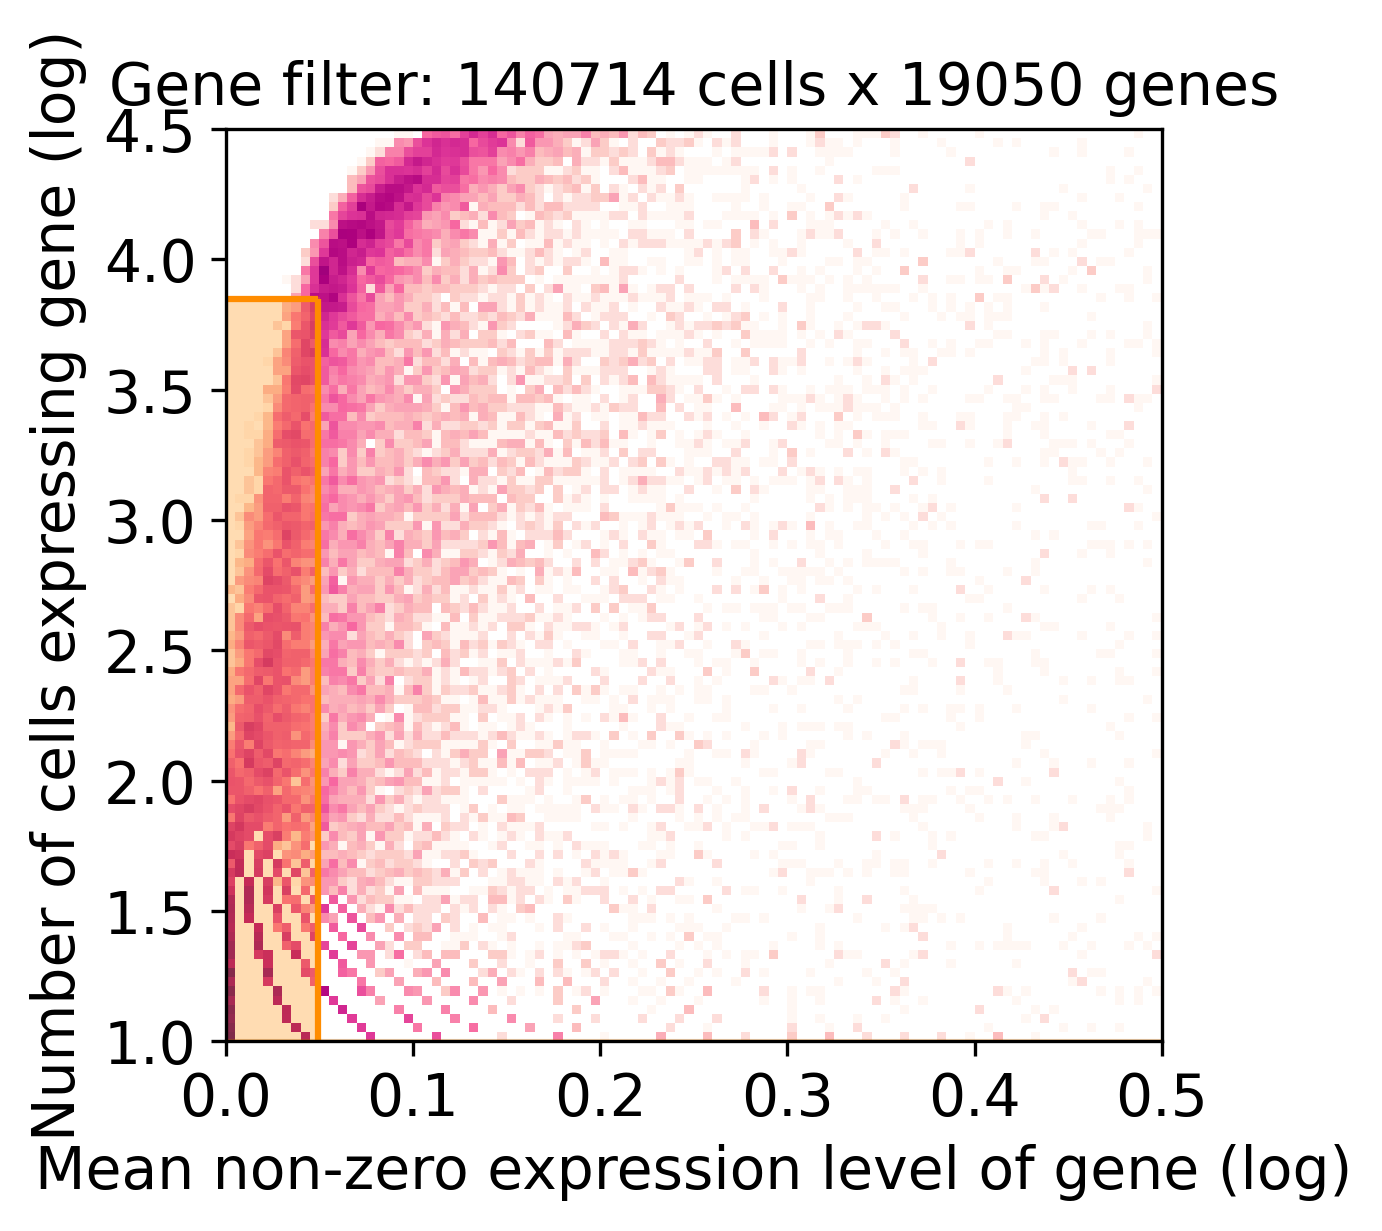

In [24]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.05, nonz_mean_cutoff=1.12)

In [25]:
adata_ref = adata_ref[:,selected].copy()

adata_ref.shape

(140714, 19050)

sc.pp.highly_variable_genes(
        adata_ref,
        n_top_genes=15000, # after removing all the above this is quite wide consider selecting less genes
        subset=True,
        # layer='counts',
        flavor="seurat_v3",
        batch_key="cell_type_level_4", # consider using the actual cell annotation level here i'm not quite sure what is best 
        span=1,
    )

## Estimation of reference cell type signatures (NB regression) <a class="anchor" id="Estimating_signatures"></a>

The signatures are estimated from scRNA-seq data, accounting for batch effect, using a Negative binomial regression model.

In [26]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref, 
                        # 10X reaction / sample / batch
                        batch_key='sample', 
                        # cell type, covariate used for constructing signatures
                        labels_key='cell_type_level_4', 
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['chemistry_simple','study','donor'],
                        continuous_covariate_keys=['age_numeric']
                       )

In [27]:
# create and train the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref) 
# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.19.0.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': 'cell_type_level_4',
│   'categorical_covariate_keys': ['chemistry_simple', 'study', 'donor'],
│   'continuous_covariate_keys': ['age_numeric']
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   44   │
│         n_cells          │ 140714 │
│ n_extra_categorical_covs │   3    │
│ n_extra_continuous_covs  │   1    │
│         n_labels         │   63   │
│          n_vars          │ 19050  │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                          batch State Registry                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃        Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │        GSM4838951        │          0          │
│                     │        GSM4838952        │          1          │
│                     │        GSM4838953        │          2          │
│                     │        GSM4838954        │          3          │
│                     │   T03_TH_TOT_5GEX_1_S1   │          4          │
│                     │   T03_TH_TOT_5GEX_2_S2   │          5          │
│                     │   T06_TH_TOT_5GEX_1_S9   │          6          │
│                     │  T06_TH_TOT_5GEX_2_S10   │          7          │
│                     │  T06_TH_TOT_5GEX_3_S11   │          8          │
│                     │  T06_TH_TOT_5GEX_4_S12   │          9          │
│                     │     T07_TH_EPCAM_S3      │         10          │
│                     │     T07_TH_TOT_1_S1      │         11          │
│                     │     T07_TH_TOT_2_S2      │         12          │
│                     │        TA9260012         │         13          │
│                     │        TA9260013         │         14          │
│                     │        TA9260014         │         15          │
│                     │        TA9260015         │         16          │
│                     │        TA9260016         │         17          │
│                     │        TA9260017         │         18          │
│                     │          TTA10           │         19          │
│                     │          TTA13           │         20          │
│                     │          TTA14           │         21          │
│                     │           TTA7           │         22          │
│                     │           TTA8           │         23          │
│                     │           TTA9           │         24          │
│                     │     U40-THY-0-SC-F-1     │         25          │
│                     │     U40-THY-0-SC-F-2     │         26          │
│                     │   U48-THY-0-SC-1_5GEX    │         27          │
│                     │ U48-THY-0-SC-EPCP-1_5GEX │         28          │
│                     │ U48-THY-0-SC-EPCP-2_5GEX │         29          │
│                     │          baut4           │         30          │
│                     │          baut5           │         31          │
│                     │          baut6           │         32          │
│                     │         sample1          │         33          │
│                     │         sample10         │         34          │
│                     │         sample11         │         35          │
│                     │         sample12         │         36          │
│                     │         sample2          │         37          │
│                     │         sample3          │         38          │
│                     │         sample4          │         39          │
│                     │         sample5          │         40          │
│                     │         sample6          │         41          │
│                     │         sample8          │         42          │
│                     │         sample9          │         43          │
└─────────────────────┴──────────────────────────┴─────────────────────┘

                           labels State Registry                           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location         ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type_level_4'] │     B-memory     │          0          │
│                                │     B-naive      │          1          │
│                                │     B-plasma     │          2          │
│                                │       DC1        │          3          │
│                                │       DC2        │          4          │
│                                │      EC-Art      │          5          │
│                                │    EC-Art-ELN    │          6          │
│                                │      EC-Cap      │          7          │
│                                │   EC-Lymphatic   │          8          │
│                                │      EC-Ven      │          9          │
│                                │    InterloFb     │         10          │
│                                │ Macrophage-APOC2 │         11          │
│                                │ Macrophage-SPIC1 │         12          │
│                                │  Monocyte_IL1B   │         13          │
│                                │    Myelocyte     │         14          │
│                                │    Neutrophil    │         15          │
│                                │     Pericyte     │         16          │
│                                │  Pericyte_CCL19  │         17          │
│                                │ Pericyte_COL1A1  │         18          │
│                                │     PeriloFb     │         19          │
│                                │       SMC        │         20          │
│                                │  TEC-cilliated   │         21          │
│                                │     TEC-myo      │         22          │
│                                │    TEC-neuro     │         23          │
│                                │      T_CD4       │         24          │
│                                │      T_CD8       │         25          │
│                                │   T_CD8_memory   │         26          │
│                                │    T_CD8αα(I)    │         27          │
│                                │   T_CD8αα(II)    │         28          │
│                                │  T_CD8αα(entry)  │         29          │
│                                │     T_DN(P)      │         30          │
│                                │     T_DN(Q)      │         31          │
│                                │   T_DN(early)    │         32          │
│                                │     T_DP(P)      │         33          │
│                                │     T_DP(Q)      │         34          │
│                                │   T_DP(Q)-CD99   │         35          │
│                                │  T_DP(Q)-early   │         36          │
│                                │ T_DP(Q)-late_vdj │         37          │
│                                │      T_ETP       │         38          │
│                                │       T_NK       │         39          │
│                                │ T_Treg(agonist)  │         40          │
│                                │  T_Treg-diff_1   │         41          │
│                                │  T_Treg-diff_2   │         42          │
│                                │    T_Treg_CD8    │         43          │
│                                │  T_Treg_mature   │         44          │
│                                │  T_Treg_recirc   │         45          │
│                                │   T_αβT(entry)   │         46          │
│                                │      T_γδT       │         47          │
│                                │       aDC1   

                     extra_categorical_covs State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃       Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['chemistry_simple'] │          3GEX          │          0          │
│                               │          5GEX          │          1          │
│                               │                        │                     │
│      adata.obs['donor']       │           P1           │          0          │
│                               │           P3           │          1          │
│                               │          T03           │          2          │
│                               │          T06           │          3          │
│                               │          T07           │          4          │
│                               │        TSC-CT10        │          5          │
│                               │        TSC-CT12        │          6          │
│                               │        TSC-CT13        │          7          │
│                               │        TSC-CT8         │          8          │
│                               │        TSC-CT9         │          9          │
│                               │          U09           │         10          │
│                               │          U40           │         11          │
│                               │          U48           │         12          │
│                               │          Z11           │         13          │
│                               │       baut_paed1       │         14          │
│                               │       baut_paed2       │         15          │
│                               │         camp1          │         16          │
│                               │                        │                     │
│      adata.obs['study']       │      Bautista2021      │          0          │
│                               │     Campinoti2020      │          1          │
│                               │        Park2020        │          2          │
│                               │  SpatialAtlas-Taghon   │          3          │
│                               │ SpatialAtlas-Teichmann │          4          │
│                               │                        │                     │
└───────────────────────────────┴────────────────────────┴─────────────────────┘

extra_continuous_covs State 
          Registry          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['age_numeric'] │
└──────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 2/250:   0%|▏                                        | 1/250 [00:09<37:21,  9.00s/it, v_num=1, elbo_train=1.11e+9]

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Epoch 250/250: 100%|██████████████████████████████████████| 250/250 [39:14<00:00,  9.70s/it, v_num=1, elbo_train=7.4e+8]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████████████████████████████████| 250/250 [39:14<00:00,  9.42s/it, v_num=1, elbo_train=7.4e+8]


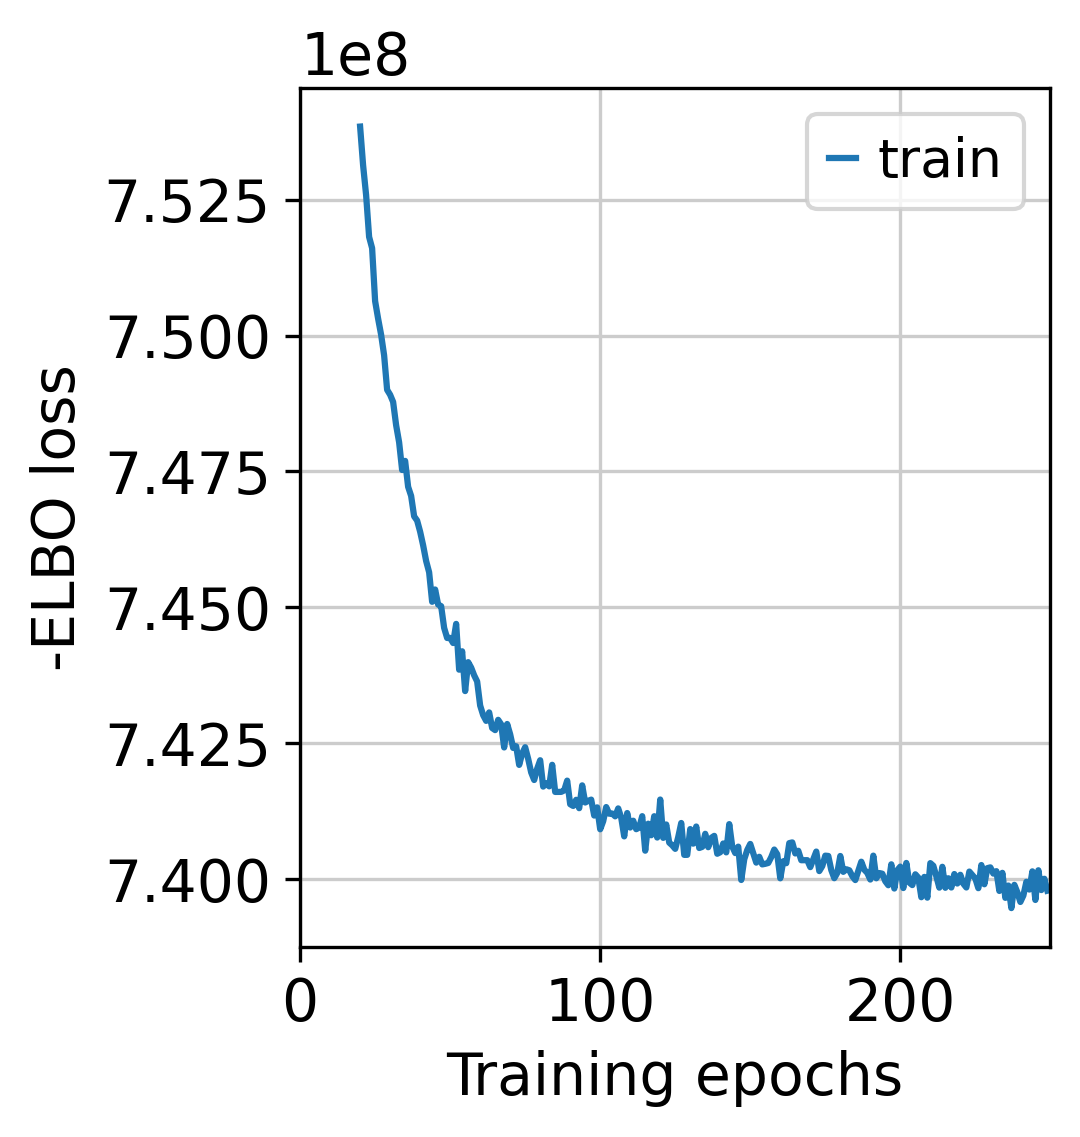

In [28]:
# Use all data for training (validation not implemented yet, train_size=1)
mod.train(max_epochs=250, batch_size=2500, train_size=1, lr=0.002, use_gpu=True)

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(20)

In [29]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

Sampling global variables, sample: 100%|██████████████████████████████████████████████| 999/999 [00:11<00:00, 84.92it/s]


In [30]:
# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

In [31]:
mod.plot_QC()

In [33]:
inf_aver.iloc[0:5, 0:5]

,B-memory,B-naive,B-plasma,DC1,DC2
AL732372.1,0.908630,0.923699,0.975726,0.979392,0.954982
LINC01128,0.041661,0.029258,0.044041,0.079283,0.264408
AL645608.2,1.074383,1.008903,1.063823,0.982780,1.032327
SAMD11,0.000527,0.000740,0.009861,0.002648,0.009628
NOC2L,0.191777,0.104302,0.276732,0.423009,0.304147


In [34]:
#load single cell file 
adata_ref = sc.read_h5ad(f"{ref_run_name}/sc.h5ad")
adata_ref

AnnData object with n_obs × n_vars = 140714 × 19050
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_r

In [35]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,B-memory,B-naive,B-plasma,DC1,DC2
AL732372.1,0.908630,0.923699,0.975726,0.979392,0.954982
LINC01128,0.041661,0.029258,0.044041,0.079283,0.264408
AL645608.2,1.074383,1.008903,1.063823,0.982780,1.032327
SAMD11,0.000527,0.000740,0.009861,0.002648,0.009628
NOC2L,0.191777,0.104302,0.276732,0.423009,0.304147


## Cell2location: spatial mapping <a class="anchor" id="cell2location"></a>

In [36]:
#The model and output h5ad can be loaded later like this:
adata_vis_all = sc.read("")

In [37]:
adata_vis = adata_vis_all[adata_vis_all.obs['Age_group'] != 'fetal'].copy()

In [38]:
adata_vis.uns['spatial']['spaceranger122_count_34880_WSSS_THYst9142087_GRCh38-2020-A']['scalefactors'].keys()

dict_keys(['fiducial_diameter_fullres', 'spot_diameter_fullres', 'tissue_hires5K_scalef', 'tissue_hires_scalef', 'tissue_lowres_scalef'])

In [39]:
for i in adata_vis.uns['spatial'].keys():
    print(f'Deleting images from {i}')
    del adata_vis.uns['spatial'][i]['images']['hires']
    if 'hires5K' in adata_vis.uns['spatial'][i]['images'].keys():
        print("has hires")
        del adata_vis.uns['spatial'][i]['images']['hires5K']
    del adata_vis.uns['spatial'][i]['scalefactors']['tissue_hires5K_scalef']
    del adata_vis.uns['spatial'][i]['scalefactors']['tissue_hires_scalef']

Deleting images from spaceranger122_count_34880_WSSS_THYst9142086_GRCh38-2020-A
has hires
Deleting images from spaceranger122_count_34880_WSSS_THYst9142087_GRCh38-2020-A
Deleting images from spaceranger122_count_34880_WSSS_THYst9142088_GRCh38-2020-A
has hires
Deleting images from spaceranger122_count_34880_WSSS_THYst9142089_GRCh38-2020-A
has hires
Deleting images from spaceranger122_count_36136_WSSS_THYst9518030_GRCh38-2020-A
has hires
Deleting images from spaceranger122_count_36136_WSSS_THYst9518032_GRCh38-2020-A
has hires
Deleting images from spaceranger122_count_36136_WSSS_THYst9518033_GRCh38-2020-A
has hires
Deleting images from spaceranger130_count_36654_WSSS_F_IMMsp9838711_GRCh38-2020-A
has hires
Deleting images from spaceranger130_count_36811_WSSS_F_IMMsp9838716_GRCh38-2020-A
has hires
Deleting images from spaceranger130_count_42337_TA11486161_GRCh38-2020-A
has hires
Deleting images from spaceranger130_count_42337_TA11486162_GRCh38-2020-A
has hires
Deleting images from spacerang

In [40]:
adata_vis.uns['spatial']['spaceranger122_count_34880_WSSS_THYst9142086_GRCh38-2020-A']['scalefactors'].keys()

dict_keys(['fiducial_diameter_fullres', 'spot_diameter_fullres', 'tissue_lowres_scalef'])

In [41]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]
# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()

In [42]:
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]
adata_vis

View of AnnData object with n_obs × n_vars = 38245 × 36588
    obs: 'Sample', 'Sample_hr', 'SampleID', 'SlideID', 'Position', 'in_tissue', 'array_row', 'array_col', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'percent_mito', 'annotations_level_0', 'annotations_level_0_number', 'annotations_level_1', 'annotations_level_1_number', 'annotations_lobules_0', 'annotations_lobules_0_number', 'L2_dist_annotations_level_0_Artifacts', 'L2_dist_annotations_level_0_Cortex', 'L2_dist_annotations_level_0_Edge', 'L2_dist_annotations_level_0_Medulla', 'L2_dist_annotations_level_1_HS', 'L2_dist_annotations_level_1_PVS', 'L2_dist_annotations_level_1_fat', 'L2_dist_annotations_level_1_vessels', 'L2_dist_annotations_level_0_lymph', 'L2_dist_annotations_level_1_unassigned', 'cm', 'cc', 'cma_v2', 'manual_bin_cma_v2', 'manual_bin_cma_v2_int', 'Image_name', 'Image_jpg', 'section_thickness (um)', 'permebialisation(min)', 'RIN/DV200', 'Visium_type', 'Funding',

In [43]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
#adata_vis = adata_vis[~adata_vis.obs['SampleID'].isin(['S000001583_U11FO2_D1_st9142089',\
#                                                     'V11J11-100_Z1-THY-FO2_A1_TA11486161',\
                                                 #   'V19D02-039_U09-THY-FO1a_C1_st9518032', \
#                                                    ]), intersect].copy()
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

In [44]:
intersect.shape

(19050,)

In [45]:
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="SampleID",
                                                categorical_covariate_keys=['SlideID', 'section_thickness (um)'],continuous_covariate_keys=['Age(numeric)','n_genes_by_counts'])

Here you need to specify 2 user-provided hyperparameters (`N_cells_per_location` and `detection_alpha`) - for detailed guidance on setting these hyperparameters and their impact see [the flow diagram and the note](https://github.com/BayraktarLab/cell2location/blob/master/docs/images/Note_on_selecting_hyperparameters.pdf).

<div class="alert alert-block alert-danger">
<b>Note!</b>
While you can often use the default value of `detection_alpha` hyperparameter, it is useful to  <b>adapt the expected cell abundance `N_cells_per_location` to every tissue</b>. This value can be estimated from paired histology images and as described in the note above. Change the value presented in this tutorial (`N_cells_per_location=30`) to the value observed in your your tissue.
</div>

In [46]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver, 
    # the expected average cell abundance: tissue-dependent 
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=50,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=20
) 

mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.19.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'SampleID',
│   'labels_key': None,
│   'categorical_covariate_keys': ['SlideID', 'section_thickness (um)'],
│   'continuous_covariate_keys': ['Age(numeric)', 'n_genes_by_counts']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  16   │
│         n_cells          │ 38245 │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   2   │
│         n_labels         │   1   │
│          n_vars          │ 19050 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                       batch State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃    Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['SampleID'] │    TA11486161     │          0          │
│                       │    TA11486162     │          1          │
│                       │    TA11486163     │          2          │
│                       │    TA11486164     │          3          │
│                       │    TA11556492     │          4          │
│                       │    TA11556493     │          5          │
│                       │    TA11556494     │          6          │
│                       │    TA11556495     │          7          │
│                       │    TA11556496     │          8          │
│                       │ WSSS_THYst9142086 │          9          │
│                       │ WSSS_THYst9142087 │         10          │
│                       │ WSSS_THYst9142088 │         11          │
│                       │ WSSS_THYst9142089 │         12          │
│                       │ WSSS_THYst9518030 │         13          │
│                       │ WSSS_THYst9518032 │         14          │
│                       │ WSSS_THYst9518033 │         15          │
└───────────────────────┴───────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                  extra_categorical_covs State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃           Source Location           ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│        adata.obs['SlideID']         │ V11J11-099 │          0          │
│                                     │ V11J11-100 │          1          │
│                                     │ V11J11-102 │          2          │
│                                     │ V19D02-039 │          3          │
│                                     │ V19S16-069 │          4          │
│                                     │            │                     │
│ adata.obs['section_thickness (um)'] │     7      │          0          │
│                                     │     10     │          1          │
│                                     │            │                     │
└─────────────────────────────────────┴────────────┴─────────────────────┘

   extra_continuous_covs State    
             Registry             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   adata.obs['Age(numeric)']    │
│ adata.obs['n_genes_by_counts'] │
└────────────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 2/30000:   0%|                                   | 1/30000 [00:00<2:51:59,  2.91it/s, v_num=1, elbo_train=4.83e+8]

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Epoch 17716/30000:  59%|██████████████▊          | 17715/30000 [1:39:03<1:08:26,  2.99it/s, v_num=1, elbo_train=2.37e+8]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 22084/30000:  74%|███████████████████▊       | 22083/30000 [2:03:25<44:13,  2.98it/s, v_num=1, elbo_train=2.37e+8]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 26300/30000:  88%|███████████████████████▋   | 26299/30000 [2:26:55<20:50,  2.96it/s, v_num=1, elbo_train=2.37e+8]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 30000/30000: 100%|███████████████████████████| 30000/30000 [2:47:34<00:00,  3.01it/s, v_num=1, elbo_train=2.37e+8]

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|███████████████████████████| 30000/30000 [2:47:34<00:00,  2.98it/s, v_num=1, elbo_train=2.37e+8]


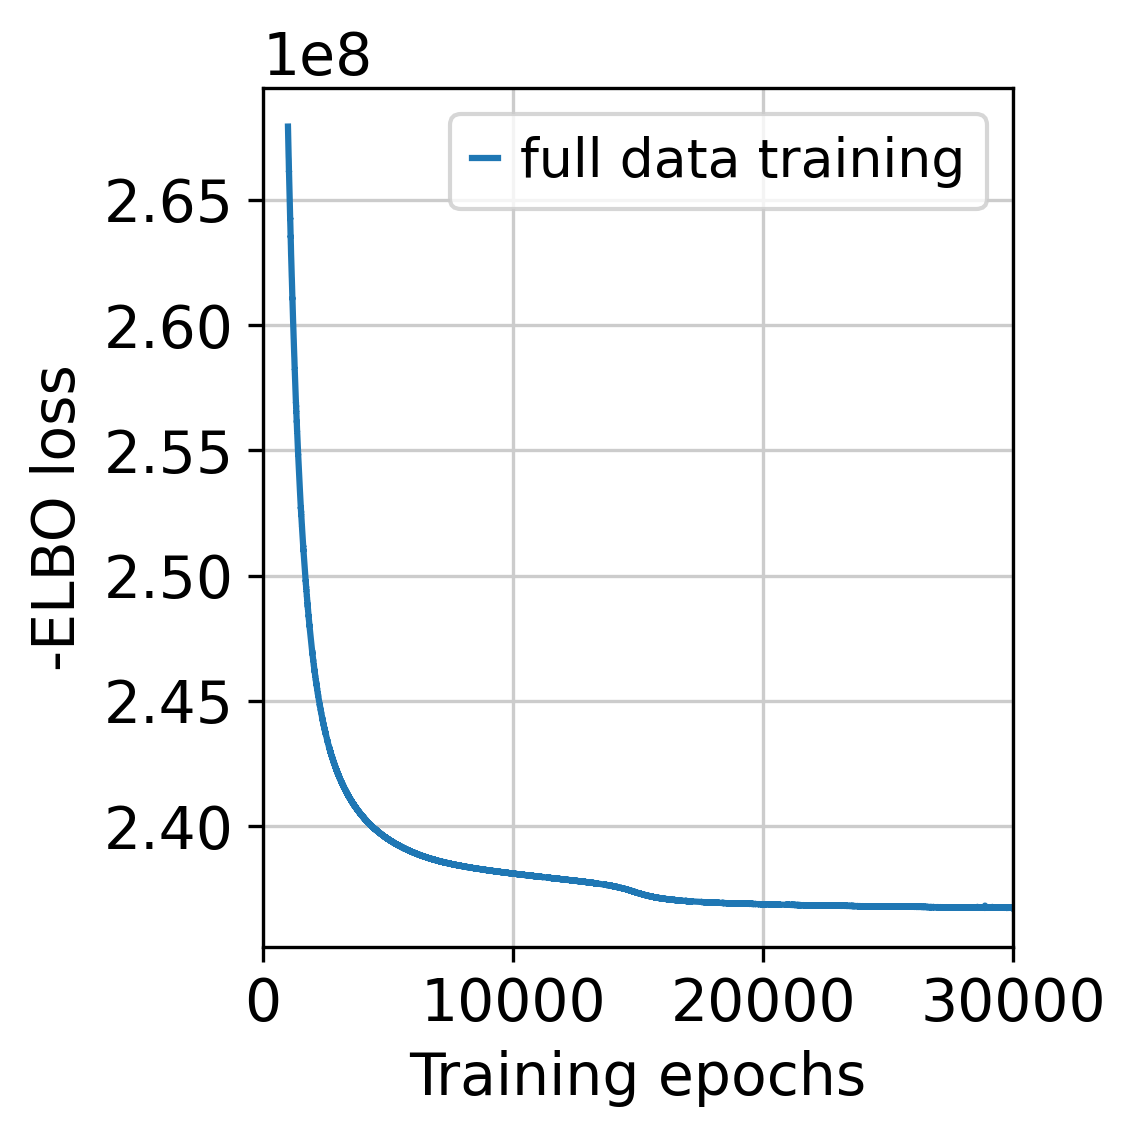

In [47]:
mod.train(max_epochs=30000, 
          # train using full data (batch_size=None)
          batch_size=None, 
          # use all data points in training because 
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [48]:
run_name

'/nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v9_anno_v11_paed_sub_10K/cell2location_map'

In [49]:
# Save model and visium data 
os.mkdir(run_name)
adata_file = f"{run_name}/adata_vis.h5ad"
adata_vis.write(adata_file)
mod.save(f"{run_name}", overwrite=True)

# consider restarting kernel before this state to prevent GPU from crashing


In [6]:
# load model and visium data 
adata_vis = sc.read_h5ad(f"{run_name}/adata_vis.h5ad")
mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

INFO     File /nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v9_anno_v11_paed_su
         b_10K/cell2location_map/model.pt already downloaded                                 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/30000:   0%|                                   | 1/30000 [00:00<2:49:41,  2.95it/s, v_num=1, elbo_train=4.83e+8]

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/30000:   0%|                                   | 1/30000 [00:00<2:52:04,  2.91it/s, v_num=1, elbo_train=4.83e+8]


In [7]:
# load single cell file 
adata_ref = sc.read_h5ad(f"{ref_run_name}/sc.h5ad")
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,B-memory,B-naive,B-plasma,DC1,DC2
AL732372.1,0.908630,0.923699,0.975726,0.979392,0.954982
LINC01128,0.041661,0.029258,0.044041,0.079283,0.264408
AL645608.2,1.074383,1.008903,1.063823,0.982780,1.032327
SAMD11,0.000527,0.000740,0.009861,0.002648,0.009628
NOC2L,0.191777,0.104302,0.276732,0.423009,0.304147


In [8]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

Sampling global variables, sample: 100%|██████████████████████████████████████████████| 999/999 [00:51<00:00, 19.49it/s]


In [9]:
# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file